# Load Dataset

In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="CxmnmwblpBjFuOlo5vKY")
project = rf.workspace("bestgetsbetter").project("jpj")
version = project.version(1)
dataset = version.download("yolov12")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 79.2 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.3


Extracting Dataset Version Zip to JPJ-1 in yolov12:: 100%|██████████| 2275/2275 [00:00<00:00, 8860.57it/s]


In [2]:
# ============================================================
# INSTALL & IMPORTS
# ============================================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import glob
import os
import random

In [3]:
root = dataset.location
print("Dataset root folder:", root)

# Auto-detect all image folders
possible_subfolders = ["train", "valid", "test"]
image_paths = []

for subset in possible_subfolders:
    # Check direct folder: /train/*.jpg
    path1 = os.path.join(root, subset)
    # Check YOLO folder: /train/images/*.jpg
    path2 = os.path.join(root, subset, "images")

    if os.path.exists(path1):
        image_paths.extend(glob.glob(path1 + "/*.jpg"))
        image_paths.extend(glob.glob(path1 + "/*.png"))

    if os.path.exists(path2):
        image_paths.extend(glob.glob(path2 + "/*.jpg"))
        image_paths.extend(glob.glob(path2 + "/*.png"))

# Pick 3 sample images
sample_imgs = image_paths[:3]

print("Found images:", len(image_paths))
print("Selected 3 images:")
for p in sample_imgs:
    print(p)

Dataset root folder: /kaggle/working/JPJ-1
Found images: 1133
Selected 3 images:
/kaggle/working/JPJ-1/train/images/2023-06-15_14-23-57-front_mp4_780_jpg.rf.256bcd78125ac6b09ea33f9c5da7efb1.jpg
/kaggle/working/JPJ-1/train/images/Virtual_Driving_Tour_around_Senegal_mp4_18180_jpg.rf.54bc46052cd1592f4fef2e159858daf6.jpg
/kaggle/working/JPJ-1/train/images/2023-06-15_14-36-00-front_mp4_1740_jpg.rf.80b8e7b9e0fe98d3510abf12920b2fe0.jpg


# Define Intensity Transformation Functions

In [4]:
# ============================================================
# INTENSITY TRANSFORMATION FUNCTIONS
# ============================================================

def log_transformation(img):
    img = img.astype(np.float32)
    c = 255 / np.log(1 + np.max(img))
    log_img = c * (np.log(img + 1))
    return np.uint8(np.clip(log_img, 0, 255))

def gamma_correction(img, gamma=1.5):
    img_normalized = img / 255.0
    gamma_img = np.power(img_normalized, gamma)
    return np.uint8(gamma_img * 255)

def contrast_stretching(img):
    r_min, r_max = np.min(img), np.max(img)
    stretched = (img - r_min) * (255 / (r_max - r_min))
    return np.uint8(stretched)

def clahe_equalization(img):
    if len(img.shape) == 3: 
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        L, A, B = cv2.split(lab)

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        L_clahe = clahe.apply(L)

        final = cv2.merge((L_clahe, A, B))
        return cv2.cvtColor(final, cv2.COLOR_LAB2BGR)
    else:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        return clahe.apply(img)

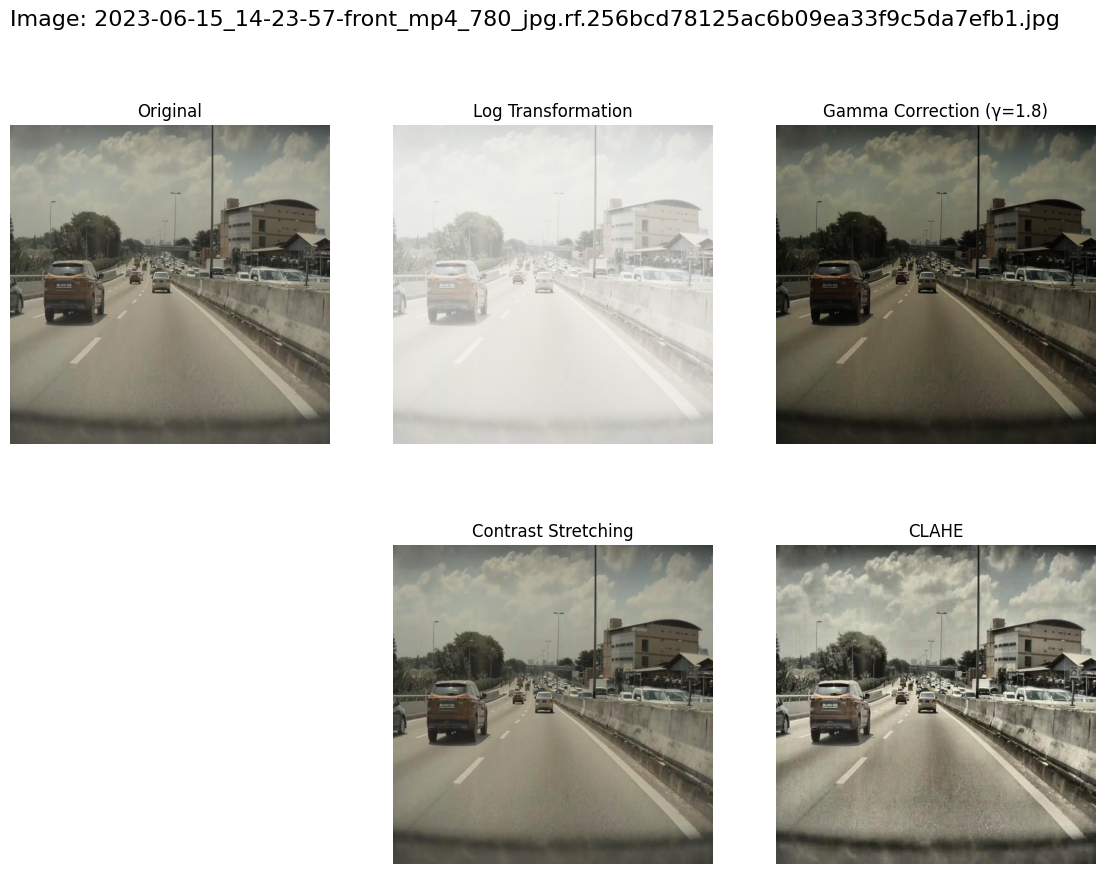

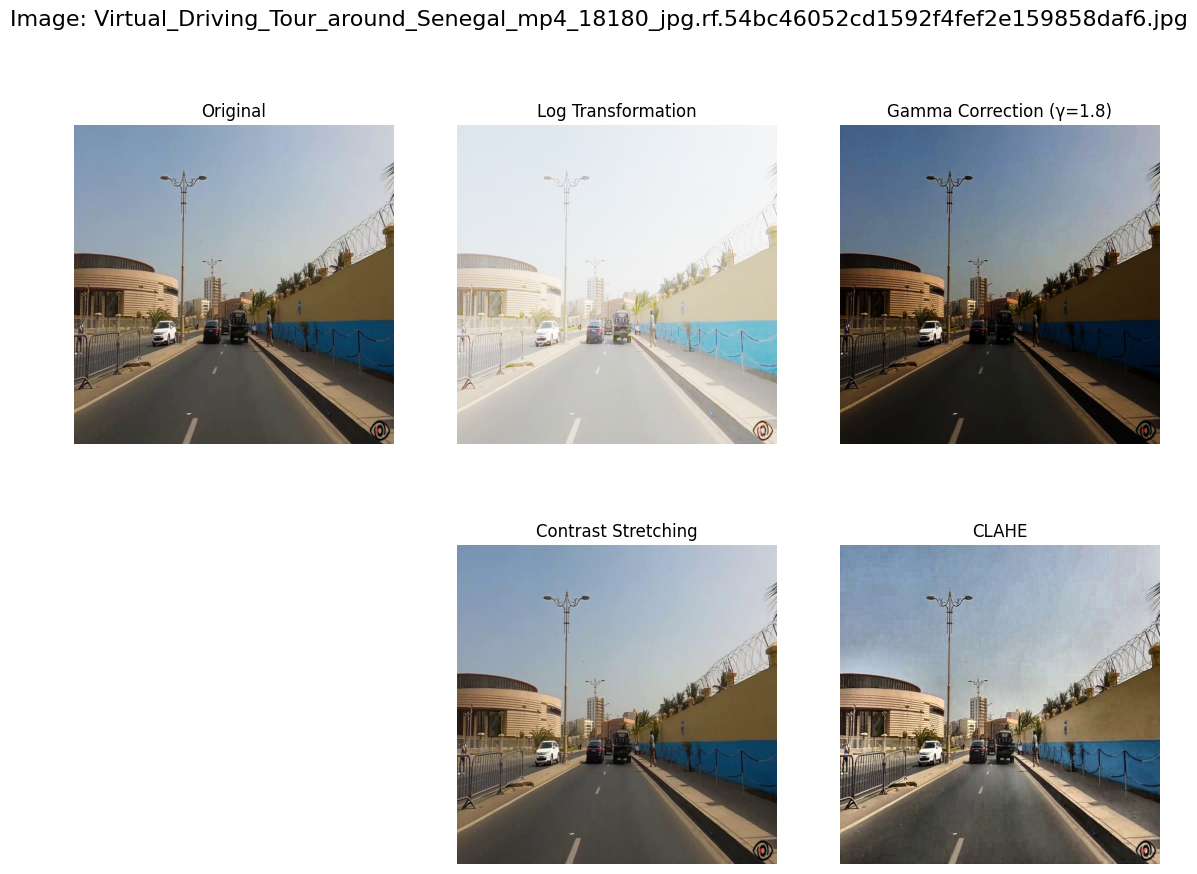

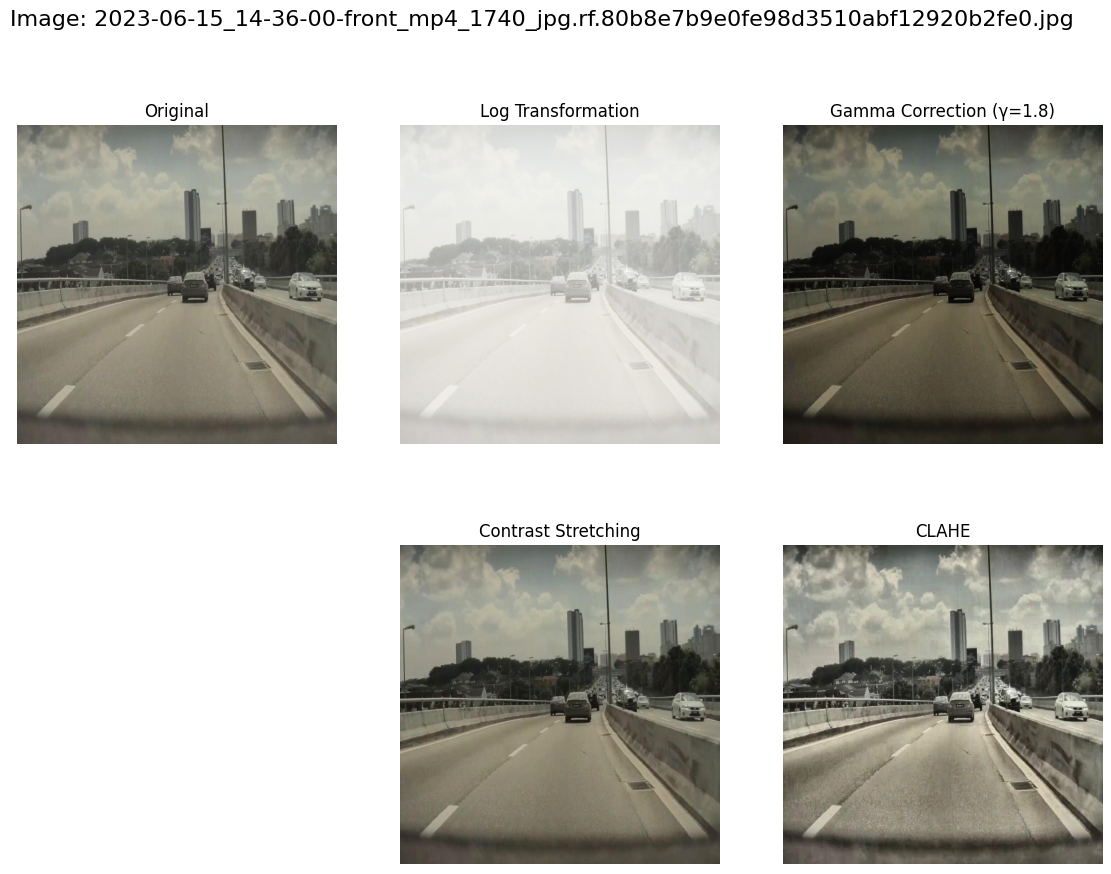

In [5]:
# ============================================================
# APPLY TRANSFORMATIONS & DISPLAY
# ============================================================

for img_path in sample_imgs:

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # for matplotlib

    # Apply transformations
    log_img = log_transformation(img)
    gamma_img = gamma_correction(img, gamma=1.8)
    stretch_img = contrast_stretching(img)
    clahe_img = clahe_equalization(img)

    # Plot outputs
    plt.figure(figsize=(14, 10))
    plt.suptitle(f"Image: {os.path.basename(img_path)}", fontsize=16)

    plt.subplot(2, 3, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(2, 3, 2)
    plt.imshow(log_img)
    plt.title("Log Transformation")
    plt.axis("off")

    plt.subplot(2, 3, 3)
    plt.imshow(gamma_img)
    plt.title("Gamma Correction (γ=1.8)")
    plt.axis("off")

    plt.subplot(2, 3, 5)
    plt.imshow(stretch_img)
    plt.title("Contrast Stretching")
    plt.axis("off")

    plt.subplot(2, 3, 6)
    plt.imshow(clahe_img)
    plt.title("CLAHE")
    plt.axis("off")

    plt.show()

# Define Filtering Functions

In [6]:
# ============================================================
# FILTER FUNCTIONS
# ============================================================

def mean_filter(img, ksize=5):
    return cv2.blur(img, (ksize, ksize))

def gaussian_filter(img, ksize=5, sigma=1):
    return cv2.GaussianBlur(img, (ksize, ksize), sigma)

def median_filter(img, ksize=5):
    return cv2.medianBlur(img, ksize)

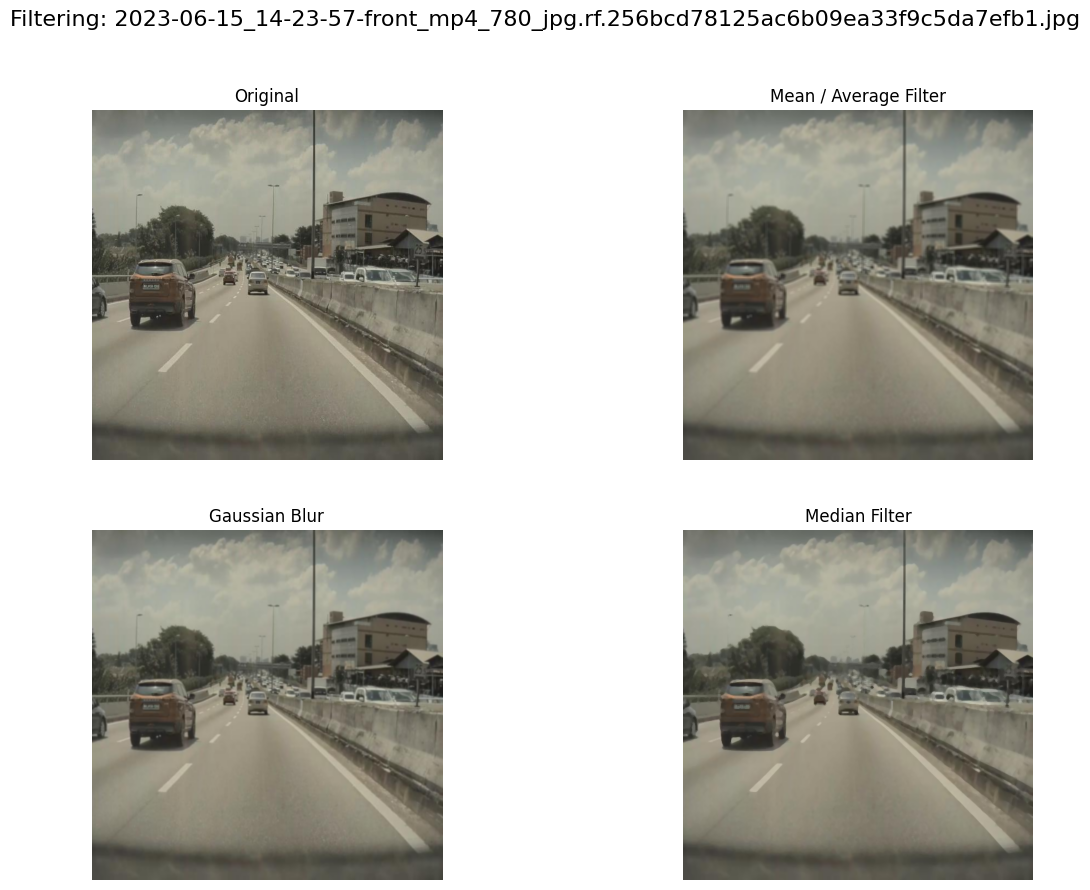

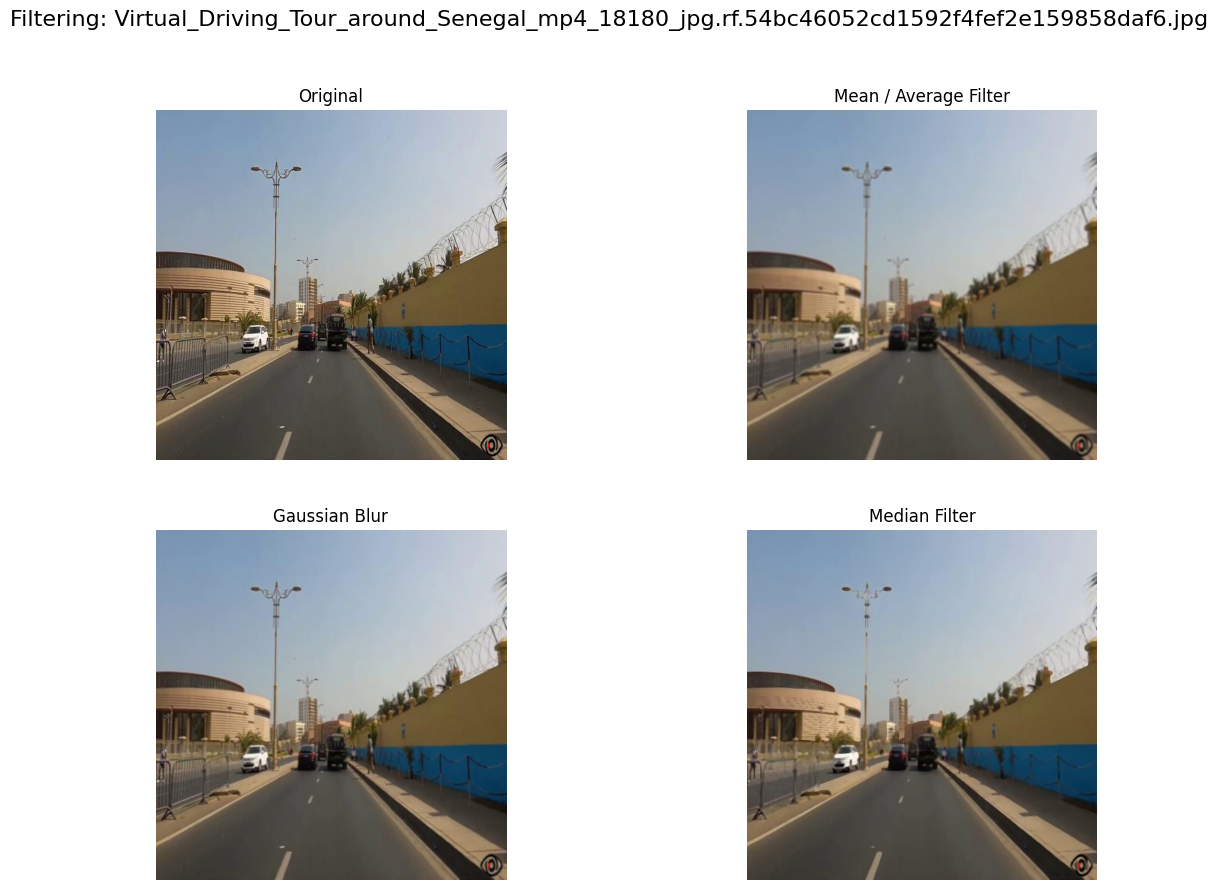

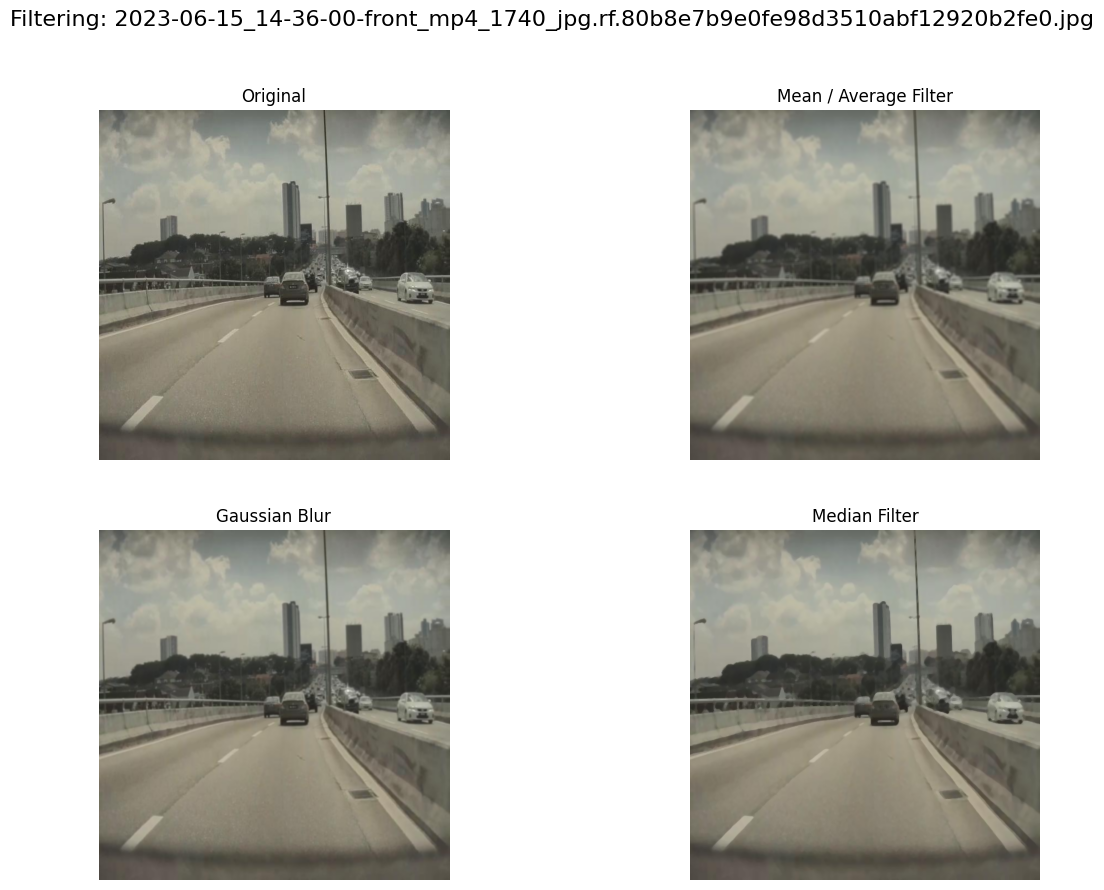

In [7]:
# ============================================================
# APPLY FILTERS & DISPLAY
# ============================================================

for img_path in sample_imgs:

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mean_img = mean_filter(img, ksize=5)
    gaussian_img = gaussian_filter(img, ksize=5, sigma=1)
    median_img = median_filter(img, ksize=5)

    plt.figure(figsize=(14, 10))
    plt.suptitle(f"Filtering: {os.path.basename(img_path)}", fontsize=16)

    plt.subplot(2, 2, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.imshow(mean_img)
    plt.title("Mean / Average Filter")
    plt.axis("off")

    plt.subplot(2, 2, 3)
    plt.imshow(gaussian_img)
    plt.title("Gaussian Blur")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    plt.imshow(median_img)
    plt.title("Median Filter")
    plt.axis("off")

    plt.show()

# Create the data.yaml file

In [8]:
%%writefile /kaggle/working/data.yaml
# ============================================================
# YOLOv12 Dataset Configuration for Instance Segmentation
# ============================================================

train: /kaggle/working/JPJ-1/train/images
val: /kaggle/working/JPJ-1/test/images
test: /kaggle/working/JPJ-1/test/images

# Number of classes
nc: 6

# Class names
names: ['divider-line','dotted-line','double-line','random-line','road-sign-line','solid-line']

Writing /kaggle/working/data.yaml


# Sample Visualization with Labels

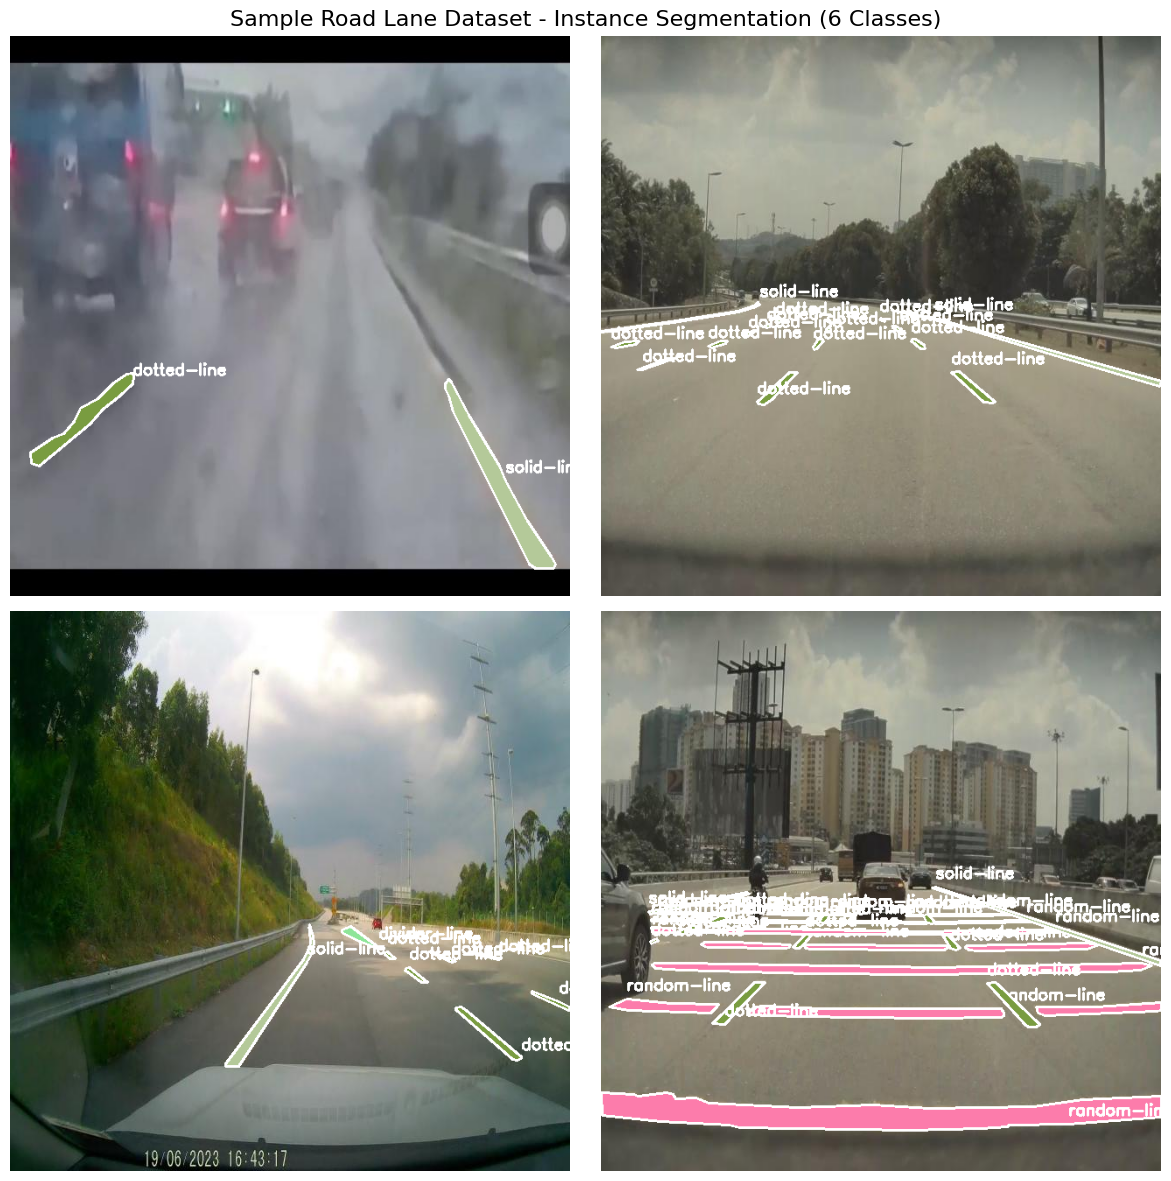

In [9]:
import os, random, cv2
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# YOLOv12 Instance Segmentation Visualization (6 Classes)
# ============================================================

# Paths
image_dir = "/kaggle/working/JPJ-1/train/images"
label_dir = "/kaggle/working/JPJ-1/train/labels"

# Class names (must match YOLO class IDs)
CLASS_NAMES = [
    "divider-line",     # class 0
    "dotted-line",      # class 1
    "double-line",      # class 2
    "random-line",      # class 3
    "road-sign-line",   # class 4
    "solid-line"        # class 5
]

# Assign fixed colors to each class for consistent visualization
np.random.seed(42)  # for consistent colors across runs
CLASS_COLORS = {
    i: tuple(np.random.randint(50, 255, 3).tolist()) for i in range(len(CLASS_NAMES))
}

# Get random sample of 4 images
image_files = random.sample(os.listdir(image_dir), 4)

def visualize_image(img_path, label_path):
    """Visualize one image with segmentation masks or bboxes for all classes."""
    img = cv2.imread(img_path)
    if img is None:
        return np.zeros((100, 100, 3), dtype=np.uint8)

    h, w = img.shape[:2]
    overlay = img.copy()

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            values = list(map(float, line.strip().split()))
            cls_id = int(values[0])
            coords = values[1:]
            class_name = CLASS_NAMES[cls_id] if cls_id < len(CLASS_NAMES) else f"class_{cls_id}"
            color = CLASS_COLORS.get(cls_id, (255, 255, 255))

            # Polygon segmentation (YOLOv12 mask format)
            if len(coords) > 4:
                pts = np.array(coords).reshape(-1, 2)
                pts[:, 0] *= w
                pts[:, 1] *= h
                pts = pts.astype(np.int32)
                cv2.fillPoly(overlay, [pts], color)
                cv2.polylines(overlay, [pts], True, (255, 255, 255), 2)
                cv2.putText(overlay, class_name, (pts[0][0], max(pts[0][1] - 10, 20)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
            else:
                # Bounding box fallback
                xc, yc, bw, bh = coords
                x1, y1 = int((xc - bw / 2) * w), int((yc - bh / 2) * h)
                x2, y2 = int((xc + bw / 2) * w), int((yc + bh / 2) * h)
                cv2.rectangle(overlay, (x1, y1), (x2, y2), color, 2)
                cv2.putText(overlay, class_name, (x1, max(y1 - 5, 20)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    return overlay


# ============================================================
# Show 4 Random Images (2x2 Grid)
# ============================================================
plt.figure(figsize=(12, 12))
for idx, img_file in enumerate(image_files):
    img_path = os.path.join(image_dir, img_file)
    label_path = os.path.join(label_dir, img_file.rsplit('.', 1)[0] + ".txt")
    vis = visualize_image(img_path, label_path)

    plt.subplot(2, 2, idx + 1)
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.axis("off")

plt.suptitle("Sample Road Lane Dataset - Instance Segmentation (6 Classes)", fontsize=16)
plt.tight_layout()
plt.show()

# Setup

In [10]:
!pip -q install --upgrade ultralytics --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.3 MB/s eta 0:00:00


In [11]:
from ultralytics import YOLO
import os, glob, random, shutil, json, gc
import matplotlib.pyplot as plt
import cv2
import numpy as np

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Point to data.yaml & quick sanity checks

In [12]:
DATA_YAML = "/kaggle/working/data.yaml"

# Show the YAML file for quick confirmation
print(open(DATA_YAML).read())

# Optional: basic file count checks (train/val/test)
import yaml
cfg = yaml.safe_load(open(DATA_YAML))
for split in ["train", "val", "test"]:
    if split in cfg and cfg[split]:
        img_dir = cfg[split]
        n = len(glob.glob(os.path.join(img_dir, "*.*")))
        print(f"{split:<5} -> {img_dir} : {n} files")

# ============================================================
# YOLOv12 Dataset Configuration for Instance Segmentation
# ============================================================

train: /kaggle/working/JPJ-1/train/images
val: /kaggle/working/JPJ-1/test/images
test: /kaggle/working/JPJ-1/test/images

# Number of classes
nc: 6

# Class names
names: ['divider-line','dotted-line','double-line','random-line','road-sign-line','solid-line']

train -> /kaggle/working/JPJ-1/train/images : 1021 files
val   -> /kaggle/working/JPJ-1/test/images : 112 files
test  -> /kaggle/working/JPJ-1/test/images : 112 files


# Train YOLOv11 (segmentation)

In [13]:
# Load a model
model = YOLO("yolo12n-seg.yaml").load("yolo12n.pt")  # build from YAML and transfer weights

# for yolov11 version
# model = YOLO("yolo11n-seg.yaml")  # build a new model from YAML
# model = YOLO("yolo11n-seg.pt")  # load a pretrained model (recommended for training)
# model = YOLO("yolo11n-seg.yaml").load("yolo11n.pt")  # build from YAML and transfer weights

results = model.train(
    data=DATA_YAML,
    epochs=50,            # adjust as needed
    imgsz=640,
    batch=8,              # tune based on GPU memory
    workers=2,
    device=0,             # 0 for GPU, 'cpu' for CPU
    patience=10,          # early stopping
    save=True,
    save_period=-1,       # set >0 to save every N epochs
    pretrained=True,
    optimizer="auto",
    project="/kaggle/working/yolo12_runs",
    name="road_yolo12_seg",
    exist_ok=True,
    amp=True              # mixed precision (faster on modern GPUs)
)

print("Training finished. Best weights should be in 'best.pt' under the run directory.")

Transferred 691/753 items from pretrained weights
Ultralytics 8.3.233 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=road_yolo12_seg, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_ma

invalid value encountered in less
invalid value encountered in less


                   all        112        982      0.639      0.731      0.744      0.559      0.587      0.675       0.68      0.388
          divider-line         21         26       0.53      0.808      0.724       0.52      0.454      0.692      0.584      0.358
           dotted-line         96        621       0.89      0.778       0.87      0.621      0.779      0.681      0.749      0.388
           double-line          3          4      0.327       0.75      0.793      0.679      0.327       0.75      0.793      0.504
           random-line         19        104      0.633      0.606      0.583       0.33      0.563      0.538      0.517      0.248
        road-sign-line         14         24      0.616      0.602      0.608      0.447      0.573      0.559      0.566      0.311
            solid-line        105        203      0.838      0.844      0.887      0.757      0.824      0.829      0.868      0.522
Speed: 0.4ms preprocess, 7.8ms inference, 0.0ms loss, 6.7ms postproce

# Validation (mAP, precision/recall, confusion matrix)

In [14]:
# Locate best weights from the run folder
run_dir = results.save_dir if hasattr(results, "save_dir") else "/kaggle/working/yolo12_runs/road_yolo12_seg"
best_ckpt = os.path.join(run_dir, "weights", "best.pt")
print("Using weights:", best_ckpt)

model = YOLO(best_ckpt)
val_metrics = model.val(split="val")   # uses val set in data.yaml

# The .val() call prints a summary and saves plots (PR curves, confusion, F1, etc.)
# You can also access metrics programmatically:
try:
    # For segmentation: metrics.box.map and metrics.seg.map exist on recent ultralytics
    print("Box  mAP50-95:", getattr(val_metrics.box, "map", None))
    print("Mask mAP50-95:", getattr(val_metrics.seg, "map", None))
except:
    pass

Using weights: /kaggle/working/yolo12_runs/road_yolo12_seg/weights/best.pt
Ultralytics 8.3.233 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO12n-seg summary (fused): 172 layers, 2,810,314 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1047.5±263.5 MB/s, size: 40.9 KB)
val: Scanning /kaggle/working/JPJ-1/test/labels.cache... 112 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 112/112 246.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 1.5it/s 4.7s


invalid value encountered in less
invalid value encountered in less


                   all        112        982      0.641       0.73      0.746       0.56      0.616      0.641      0.674      0.382
          divider-line         21         26      0.533      0.808      0.724      0.518      0.493      0.692      0.583      0.358
           dotted-line         96        621      0.889      0.776      0.872      0.628      0.799      0.649      0.735      0.367
           double-line          3          4      0.328       0.75      0.793      0.679      0.341       0.75      0.793      0.495
           random-line         19        104       0.64      0.596      0.585      0.332      0.613      0.413      0.516      0.242
        road-sign-line         14         24      0.615        0.6      0.611      0.446      0.589      0.542      0.551      0.309
            solid-line        105        203      0.843      0.848      0.891      0.756      0.861      0.797      0.868      0.519
Speed: 3.2ms preprocess, 10.3ms inference, 0.0ms loss, 6.6ms postproc

# Test set evaluation

In [15]:
# Evaluate on test split if defined in data.yaml
try:
    test_metrics = model.val(split="test")
    try:
        print("Test Box  mAP50-95:", getattr(test_metrics.box, "map", None))
        print("Test Mask mAP50-95:", getattr(test_metrics.seg, "map", None))
    except:
        pass
except Exception as e:
    print("Test evaluation skipped or failed:", e)

Ultralytics 8.3.233 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1270.7±459.5 MB/s, size: 41.7 KB)
val: Scanning /kaggle/working/JPJ-1/test/labels.cache... 112 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 112/112 184.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 1.4it/s 5.0s


invalid value encountered in less
invalid value encountered in less


                   all        112        982      0.641       0.73      0.746       0.56      0.616      0.641      0.674      0.382
          divider-line         21         26      0.533      0.808      0.724      0.518      0.493      0.692      0.583      0.358
           dotted-line         96        621      0.889      0.776      0.872      0.628      0.799      0.649      0.735      0.367
           double-line          3          4      0.328       0.75      0.793      0.679      0.341       0.75      0.793      0.495
           random-line         19        104       0.64      0.596      0.585      0.332      0.613      0.413      0.516      0.242
        road-sign-line         14         24      0.615        0.6      0.611      0.446      0.589      0.542      0.551      0.309
            solid-line        105        203      0.843      0.848      0.891      0.756      0.861      0.797      0.868      0.519
Speed: 4.1ms preprocess, 9.1ms inference, 0.1ms loss, 7.1ms postproce

# Predict & visualize a few samples from the test set


0: 640x640 8 dotted-lines, 3 solid-lines, 18.1ms
1: 640x640 1 dotted-line, 4 solid-lines, 18.1ms
2: 640x640 2 dotted-lines, 1 solid-line, 18.1ms
3: 640x640 6 dotted-lines, 1 solid-line, 18.1ms
Speed: 1.8ms preprocess, 18.1ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)


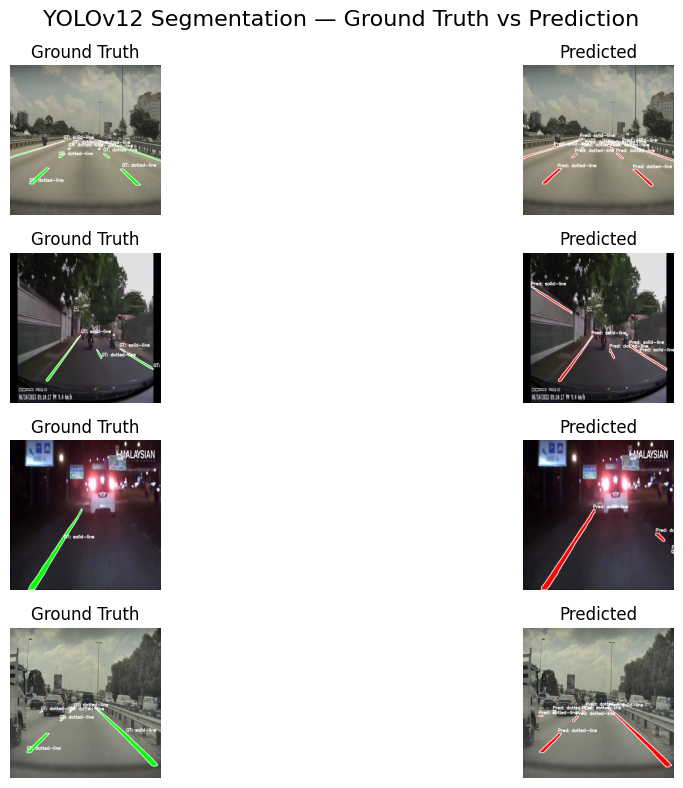

In [16]:
# ============================================================
# YOLOv12 Segmentation — Predicted vs Ground Truth Comparison
# ============================================================

import os, glob, random, cv2
import numpy as np
import matplotlib.pyplot as plt

# Pick a few random test images
test_dir = cfg.get("test")
label_dir = test_dir.replace("/images", "/labels")  # assumes standard YOLO structure

sample_imgs = []
if test_dir and os.path.isdir(test_dir):
    all_imgs = [p for p in glob.glob(os.path.join(test_dir, "*.*"))
                if p.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"))]
    sample_imgs = random.sample(all_imgs, min(4, len(all_imgs)))

# ------------------------------------------------------------
# Helper to draw polygons from YOLO label file (Ground Truth)
# ------------------------------------------------------------
def draw_gt_polygons(img_path, label_path, class_names=["divider-line",     # class 0
    "dotted-line",      # class 1
    "double-line",      # class 2
    "random-line",      # class 3
    "road-sign-line",   # class 4
    "solid-line"]):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    overlay = img.copy()

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                vals = list(map(float, line.strip().split()))
                cls_id = int(vals[0])
                coords = vals[1:]
                if len(coords) > 4:
                    pts = np.array(coords).reshape(-1, 2)
                    pts[:, 0] *= w
                    pts[:, 1] *= h
                    pts = pts.astype(np.int32)
                    color = (0, 255, 0)  # green for GT
                    cv2.fillPoly(overlay, [pts], color)
                    cv2.polylines(overlay, [pts], True, (255, 255, 255), 2)
                    label = class_names[cls_id] if cls_id < len(class_names) else str(cls_id)
                    cv2.putText(overlay, f"GT: {label}", (pts[0][0], pts[0][1] - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
    else:
        print(f"⚠️ No label file found for {os.path.basename(img_path)}")

    return overlay

# ------------------------------------------------------------
# Helper to draw predicted polygons
# ------------------------------------------------------------
def draw_pred_polygons(result):
    img = result.orig_img.copy()

    if getattr(result, "masks", None) is not None and result.masks is not None:
        for i, seg in enumerate(result.masks.xy):
            poly = np.array(seg, dtype=np.int32)
            color = (0, 0, 255)  # red for predictions
            cv2.fillPoly(img, [poly], color)
            cv2.polylines(img, [poly], True, (255, 255, 255), 2)
            if getattr(result, "names", None) is not None and getattr(result.boxes, "cls", None) is not None:
                cls_id = int(result.boxes.cls[i].item())
                label = result.names.get(cls_id, str(cls_id)) if isinstance(result.names, dict) else str(cls_id)
                x, y = poly[0]
                cv2.putText(img, f"Pred: {label}", (int(x), int(y) - 6),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
    else:
        print("⚠️ No predicted masks found for:", result.path)

    return img

# ------------------------------------------------------------
# Run inference on test set
# ------------------------------------------------------------
preds = model.predict(source=sample_imgs, imgsz=640, conf=0.25, device=0, save=False)

# ------------------------------------------------------------
# Plot Predicted vs Ground Truth
# ------------------------------------------------------------
plt.figure(figsize=(14, 8))
for i, result in enumerate(preds):
    img_path = result.path
    label_path = os.path.join(label_dir, os.path.basename(img_path).replace(".jpg", ".txt").replace(".png", ".txt"))
    
    # Prepare visualizations
    vis_pred = draw_pred_polygons(result)
    vis_gt = draw_gt_polygons(img_path, label_path)

    vis_pred_rgb = cv2.cvtColor(vis_pred, cv2.COLOR_BGR2RGB)
    vis_gt_rgb = cv2.cvtColor(vis_gt, cv2.COLOR_BGR2RGB)

    # Show side by side
    plt.subplot(len(preds), 2, 2*i + 1)
    plt.imshow(vis_gt_rgb)
    #plt.title(f"GT: {os.path.basename(img_path)}")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(len(preds), 2, 2*i + 2)
    plt.imshow(vis_pred_rgb)
    plt.title("Predicted")
    plt.axis("off")

plt.suptitle("YOLOv12 Segmentation — Ground Truth vs Prediction", fontsize=16)
plt.tight_layout()
plt.show()